### 1. Importando Librerias

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
from google.colab import drive, files
from datetime import datetime
import seaborn as sns

### 2. Importando dataset

In [7]:
drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Dataset/Transcripciones_Variables.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   archivo                                     605 non-null    object 
 1   duracion_seg                                605 non-null    float64
 2   transcripcion                               605 non-null    object 
 3   CONN_ID                                     592 non-null    object 
 4   AGENT_ID                                    592 non-null    float64
 5   SURVEY                                      592 non-null    object 
 6   1.1 Apertura de Llamada                     583 non-null    float64
 7   2.2 Alternativas de acuerdo a la necesidad  580 non-null    float64
 8   4.1 Condiciones de incumplimiento           572 non-null    float64
 9   4.2 Explica medios de pago                  506 non-null    float64
dtypes: float64(6),

In [9]:
df = df[['archivo','duracion_seg','transcripcion','CONN_ID','4.1 Condiciones de incumplimiento']]
df = df.dropna(subset=["4.1 Condiciones de incumplimiento"])

#### 2.1 Gráficas

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-431925818.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="4.1 Condiciones de incumplimiento", data=df, palette="Blues")


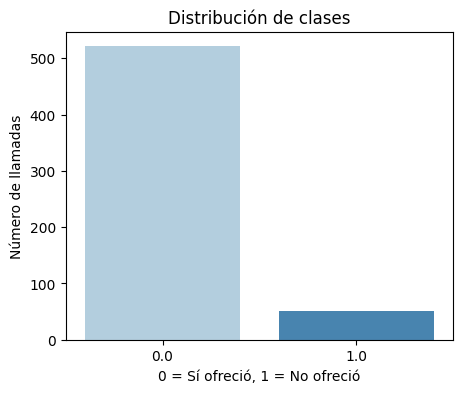

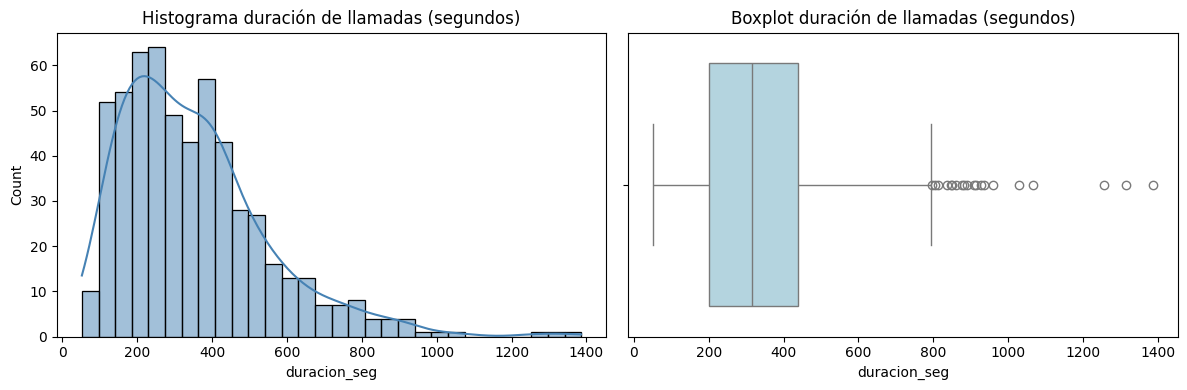

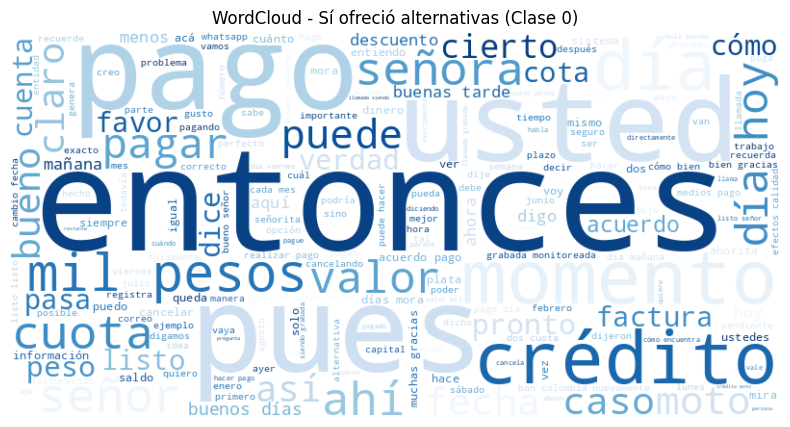

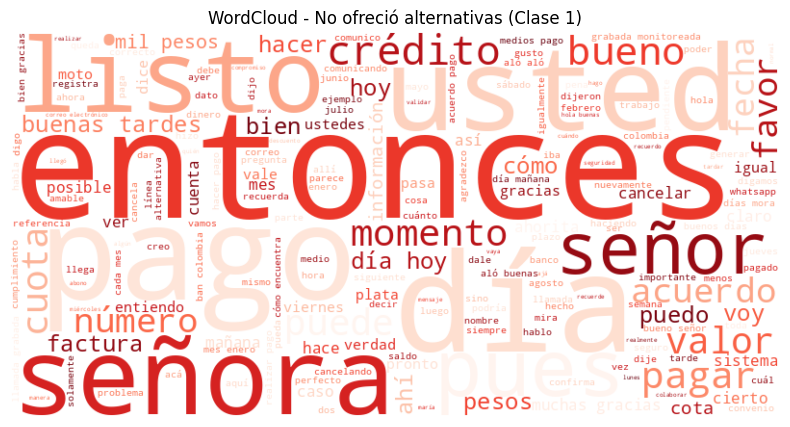

/tmp/ipython-input-431925818.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="4.1 Condiciones de incumplimiento", y="longitud", data=df, palette="Set2")


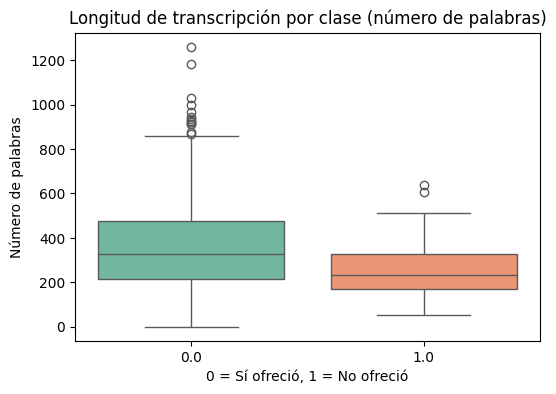

In [10]:
# !pip install seaborn wordcloud nltk
from wordcloud import WordCloud
import nltk, re
from collections import Counter

# Asegura stopwords en español
try:
    from nltk.corpus import stopwords
    _ = stopwords.words("spanish")
except:
    nltk.download("stopwords")
from nltk.corpus import stopwords
spanish_stopwords = set(stopwords.words("spanish"))

# ----------------------------
# 1) Distribución de clases
# ----------------------------
plt.figure(figsize=(5,4))
sns.countplot(x="4.1 Condiciones de incumplimiento", data=df, palette="Blues")
plt.title("Distribución de clases")
plt.xlabel("0 = Sí ofreció, 1 = No ofreció")
plt.ylabel("Número de llamadas")
plt.show()

# ----------------------------
# 2) Duración de llamadas
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Histograma
sns.histplot(df["duracion_seg"], bins=30, ax=axes[0], color="steelblue", kde=True)
axes[0].set_title("Histograma duración de llamadas (segundos)")

# Boxplot
sns.boxplot(x=df["duracion_seg"], ax=axes[1], color="lightblue")
axes[1].set_title("Boxplot duración de llamadas (segundos)")

plt.tight_layout()
plt.show()

# ----------------------------
# 3) Wordcloud (por clase)
# ----------------------------
def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r"[^a-záéíóúñü\s]", " ", texto)
    palabras = [p for p in texto.split() if p not in spanish_stopwords and len(p) > 2]
    return " ".join(palabras)

df["texto_limpio"] = df["transcripcion"].apply(limpiar_texto)

# Wordcloud clase 0
texto0 = " ".join(df.loc[df["4.1 Condiciones de incumplimiento"]==0, "texto_limpio"])
wc0 = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(texto0)

plt.figure(figsize=(10,5))
plt.imshow(wc0, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Sí ofreció alternativas (Clase 0)")
plt.show()

# Wordcloud clase 1
texto1 = " ".join(df.loc[df["4.1 Condiciones de incumplimiento"]==1, "texto_limpio"])
wc1 = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(texto1)

plt.figure(figsize=(10,5))
plt.imshow(wc1, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - No ofreció alternativas (Clase 1)")
plt.show()

# ----------------------------
# 4) Longitud de transcripción por clase
# ----------------------------
df["longitud"] = df["texto_limpio"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.boxplot(x="4.1 Condiciones de incumplimiento", y="longitud", data=df, palette="Set2")
plt.title("Longitud de transcripción por clase (número de palabras)")
plt.xlabel("0 = Sí ofreció, 1 = No ofreció")
plt.ylabel("Número de palabras")
plt.show()

### 2.1 Función para guardar resultados

Genera una fila con métricas y matriz de confusión

In [11]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, auc
)

def make_metrics_row(
    y_true, y_pred, y_score, *,
    dataset, model, sampler, vectorizer,
    threshold=0.5, n_features=None, notes=""
):
    """Devuelve 1 fila con métricas globales, por clase, PR-AUC y confusión."""
    acc        = accuracy_score(y_true, y_pred)
    f1_micro   = f1_score(y_true, y_pred, average="micro",    zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average="macro",    zero_division=0)
    f1_weight  = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    prec_1     = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec_1      = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
    f1_1       = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)

    prec_0     = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    rec_0      = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)
    f1_0       = f1_score(y_true, y_pred,        pos_label=0, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(rec_curve, prec_curve)

    return pd.DataFrame([{
        "dataset": dataset,
        "model": model,
        "sampler": sampler,
        "vectorizer": vectorizer,
        "threshold": float(threshold),
        "n_features": int(n_features) if n_features is not None else None,
        "n_samples": int(len(y_true)),
        "prevalence_1": float((y_true == 1).mean()),

        "accuracy": acc,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weight,
        "pr_auc": pr_auc,

        "precision_1": prec_1, "recall_1": rec_1, "f1_1": f1_1,
        "precision_0": prec_0, "recall_0": rec_0, "f1_0": f1_0,

        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "notes": notes,
    }])

### 3. Experimentos

#### 3.1 Baseline clasificación llamadas (TF-IDF + Logistic Regression)

Experimentos de texto (TF-IDF word/char + resampling + modelos) y Embeddings
con tuning de umbral (val) y salida "wide" por experimento

In [12]:
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

# --------- Imports ML ----------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, auc
)

# Resampling (imbalanced-learn)
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as ImbPipeline
    _HAS_IMB = True
except Exception as e:
    _HAS_IMB = False
    print("⚠️ imbalanced-learn no disponible. Se ejecutarán solo experimentos sin resampling. Error:", e)

# Stopwords español
import nltk
try:
    from nltk.corpus import stopwords
    _ = stopwords.words("spanish")
except:
    nltk.download("stopwords")
from nltk.corpus import stopwords
SPANISH_SW = stopwords.words("spanish")

# Embeddings (Sentence-Transformers)
try:
    from sentence_transformers import SentenceTransformer
    _HAS_SENT = True
except Exception as e:
    _HAS_SENT = False
    print("⚠️ sentence-transformers no disponible. Se omitirá el experimento de embeddings. Error:", e)

RSEED = 42


# =========================================================
# Helpers
# =========================================================

def tune_threshold_on_val(y_val, scores_val):
    """Devuelve el umbral que maximiza F1 de la clase positiva en el set de validación."""
    prec, rec, thr = precision_recall_curve(y_val, scores_val)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    # precision_recall_curve devuelve len(thr) = len(prec)-1
    best_idx = int(np.nanargmax(f1[:-1])) if len(thr) > 0 else 0
    thr_opt = thr[best_idx] if len(thr) > 0 else 0.5
    return float(thr_opt)


def score_from_estimator(pipe, X):
    """Obtiene scores continuos: predict_proba si existe, si no decision_function."""
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    return pipe.decision_function(X)


# =========================================================
# Núcleo: ejecutar experimentos de texto con vectorizador + sampler + modelo
# =========================================================
def _run_text_experiment(X_tr, y_tr, X_te, y_te,
                         vectorizer, vec_name,
                         sampler, sampler_name,
                         clf, model_name, notes=""):
    """Entrena con tuning de umbral (val) y devuelve fila de métricas (test)."""
    # split de validación para umbral
    X_tr_t, X_val, y_tr_t, y_val = train_test_split(
        X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=RSEED
    )
    # Pipeline (con o sin resampleo)
    steps = [("tfidf", vectorizer)]
    if sampler is not None and _HAS_IMB:
        steps.append(("sampler", sampler))
    steps.append(("clf", clf))
    pipe = ImbPipeline(steps) if (_HAS_IMB and sampler is not None) else ImbPipeline(steps)

    # Fit y threshold
    pipe.fit(X_tr_t, y_tr_t)
    n_features = pipe.named_steps["tfidf"].transform(X_tr_t).shape[1]
    val_scores = score_from_estimator(pipe, X_val)
    thr_opt = tune_threshold_on_val(y_val, val_scores)

    # Test
    test_scores = score_from_estimator(pipe, X_te)
    y_pred = (test_scores >= thr_opt).astype(int)

    row = make_metrics_row(
        y_true=y_te, y_pred=y_pred, y_score=test_scores,
        dataset="test", model=model_name, sampler=sampler_name,
        vectorizer=vec_name, threshold=thr_opt, n_features=n_features,
        notes=notes
    )
    return row


# =========================================================
# Público: función principal
# =========================================================
# Muestra el avance de los experimentos
from time import time
try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

def run_all_experiments(
    df,
    text_col="transcripcion",
    target_col="4.1 Condiciones de incumplimiento",
    test_size=0.2,
    verbose=True,
    sampler_ratios=(0.5, 1.0),   # ← NUEVO: ratios a probar
    smote_k=3                    # ← NUEVO: k vecinos para SMOTE
):
    """Corre TF-IDF (word/char) + resampling + modelos y (si disponible) embeddings + LogReg.
       Muestra progreso con barra y textos del experimento actual. Barre ratios de resampleo.
    """
    assert text_col in df.columns and target_col in df.columns, "Columnas no encontradas en df."

    X = df[text_col].astype(str)
    y = df[target_col].astype(int)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RSEED
    )

    resultados = []

    # ---------------- Vectorizadores ----------------
    word_configs = [
        dict(name="TFIDF_word(1,2)_mf5000_md2_sublinear",
             vec=TfidfVectorizer(max_features=5000, ngram_range=(1,2),
                                 min_df=2, sublinear_tf=True, stop_words=SPANISH_SW)),
        dict(name="TFIDF_word(1,2)_mf10000_md2_sublinear",
             vec=TfidfVectorizer(max_features=10000, ngram_range=(1,2),
                                 min_df=2, sublinear_tf=True, stop_words=SPANISH_SW)),
    ]
    char_configs = [
        dict(name="TFIDF_char(3,5)_md3_sublinear",
             vec=TfidfVectorizer(analyzer="char", ngram_range=(3,5),
                                 min_df=3, sublinear_tf=True)),
    ]
    vectorizers = word_configs + char_configs

    # ---------------- Samplers (con ratios) ----------------
    samplers = [("none", None)]
    if _HAS_IMB:
        for r in sampler_ratios:
            samplers += [
                (f"ROS_{r}",          RandomOverSampler(sampling_strategy=r,  random_state=RSEED)),
                (f"SMOTE_{r}",        SMOTE(sampling_strategy=r,            random_state=RSEED, k_neighbors=smote_k)),
                (f"SMOTE_Tomek_{r}",  SMOTETomek(sampling_strategy=r,       random_state=RSEED)),
            ]

    # ---------------- Modelos ----------------
    logreg_grid = [
        ("LogReg_C0.5",       LogisticRegression(C=0.5, max_iter=1000, solver="liblinear")),
        ("LogReg_C1.0",       LogisticRegression(C=1.0, max_iter=1000, solver="liblinear")),
        ("LogReg_bal_C1.0",   LogisticRegression(C=1.0, max_iter=1000, solver="liblinear", class_weight="balanced")),
    ]
    svm_calib = [
        ("LinearSVM_bal_calib",
         CalibratedClassifierCV(estimator=LinearSVC(C=1.0, class_weight="balanced", random_state=RSEED),
                                method="sigmoid", cv=3))
    ]
    rf_models = [
        ("RandomForest_bal",
         RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RSEED, class_weight="balanced_subsample"))
    ]
    model_sets = [logreg_grid, svm_calib, rf_models]

    # ------ Prepara la lista de combinaciones para mostrar progreso ------
    combos = []
    for v in vectorizers:
        for s_name, s in samplers:
            for models in model_sets:
                for m_name, clf in models:
                    combos.append((v, s_name, s, m_name, clf))

    total_runs = len(combos) + (1 if _HAS_SENT else 0)
    if verbose:
        header = f"▶️ Ejecutando {total_runs} experimentos " + ("(incluye embeddings)" if _HAS_SENT else "(sin embeddings)")
        print(header)

    prog_iter = tqdm(range(len(combos))) if (_HAS_TQDM and verbose) else range(len(combos))
    t0_all = time()

    # ---------------- Loop principal (TF-IDF) ----------------
    for i in prog_iter:
        v, s_name, s, m_name, clf = combos[i]
        vec_name = v["name"]
        if _HAS_TQDM and verbose:
            tqdm.write(f"[{i+1}/{total_runs}] vec={vec_name} | sampler={s_name} | model={m_name}")
        elif verbose:
            print(f"[{i+1}/{total_runs}] vec={vec_name} | sampler={s_name} | model={m_name}")

        t0 = time()
        try:
            row = _run_text_experiment(
                X_tr, y_tr, X_te, y_te,
                vectorizer=v["vec"], vec_name=vec_name,
                sampler=s, sampler_name=s_name,
                clf=clf, model_name=m_name,
                notes="thr tuned on val (F1_1)"
            )
            resultados.append(row)
        except Exception as e:
            err_note = f"ERROR: {type(e).__name__}: {e}"
            if verbose:
                print("   ↪︎", err_note)
            resultados.append(pd.DataFrame([{
                "dataset":"test","model":m_name,"sampler":s_name,"vectorizer":vec_name,
                "threshold":np.nan,"n_features":np.nan,"n_samples":len(y_te),"prevalence_1":float((y_te==1).mean()),
                "accuracy":np.nan,"f1_micro":np.nan,"f1_macro":np.nan,"f1_weighted":np.nan,"pr_auc":np.nan,
                "precision_1":np.nan,"recall_1":np.nan,"f1_1":np.nan,
                "precision_0":np.nan,"recall_0":np.nan,"f1_0":np.nan,
                "tn":np.nan,"fp":np.nan,"fn":np.nan,"tp":np.nan,
                "notes":err_note
            }]))
        finally:
            if verbose:
                dur = time() - t0
                msg = f"   ✓ listo en {dur:.1f}s"
                if _HAS_TQDM:
                    tqdm.write(msg)
                else:
                    print(msg)

    # ---------------- Embeddings + Logistic ----------------
    if _HAS_SENT:
        i = len(combos)
        if verbose:
            msg = f"[{i+1}/{total_runs}] vectorizer=SBERT-mpnet | sampler=none | model=LogReg_bal_C1.0"
            print(msg) if not _HAS_TQDM else tqdm.write(msg)

        enc = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
        X_tr_t, X_val, y_tr_t, y_val = train_test_split(
            X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=RSEED
        )
        t0 = time()
        try:
            Xtr_emb = enc.encode(list(X_tr_t), batch_size=64, show_progress_bar=False)
            Xval_emb = enc.encode(list(X_val),   batch_size=64, show_progress_bar=False)
            Xte_emb  = enc.encode(list(X_te),    batch_size=64, show_progress_bar=False)

            clf = LogisticRegression(C=1.0, max_iter=2000, class_weight="balanced")
            clf.fit(Xtr_emb, y_tr_t)
            val_scores = clf.predict_proba(Xval_emb)[:,1]
            thr_opt = tune_threshold_on_val(y_val, val_scores)

            test_scores = clf.predict_proba(Xte_emb)[:,1]
            y_pred = (test_scores >= thr_opt).astype(int)

            row = make_metrics_row(
                y_true=y_te, y_pred=y_pred, y_score=test_scores,
                dataset="test", model="LogReg_bal_C1.0", sampler="none",
                vectorizer="SBERT-mpnet", threshold=thr_opt,
                n_features=Xtr_emb.shape[1], notes="embeddings + logistic (thr tuned on val)"
            )
            resultados.append(row)
        except Exception as e:
            err_note = f"ERROR embeddings: {type(e).__name__}: {e}"
            if verbose:
                print("   ↪︎", err_note)
            resultados.append(pd.DataFrame([{
                "dataset":"test","model":"LogReg_bal_C1.0","sampler":"none","vectorizer":"SBERT-mpnet",
                "threshold":np.nan,"n_features":np.nan,"n_samples":len(y_te),"prevalence_1":float((y_te==1).mean()),
                "accuracy":np.nan,"f1_micro":np.nan,"f1_macro":np.nan,"f1_weighted":np.nan,"pr_auc":np.nan,
                "precision_1":np.nan,"recall_1":np.nan,"f1_1":np.nan,
                "precision_0":np.nan,"recall_0":np.nan,"f1_0":np.nan,
                "tn":np.nan,"fp":np.nan,"fn":np.nan,"tp":np.nan,
                "notes":err_note
            }]))
        finally:
            if verbose:
                dur = time() - t0
                msg = f"   ✓ embeddings listos en {dur:.1f}s"
                print(msg) if not _HAS_TQDM else tqdm.write(msg)

    if verbose:
        print(f"⏱️ Tiempo total: {time() - t0_all:.1f}s")

    # ---------------- Salida ----------------
    resultados = pd.concat(resultados, ignore_index=True)
    orden = resultados.sort_values(["f1_1","pr_auc"], ascending=False).reset_index(drop=True)
    return resultados, orden

In [13]:
resultados, ranking = run_all_experiments(df)
resultados

▶️ Ejecutando 106 experimentos (incluye embeddings)


  0%|          | 0/105 [00:00<?, ?it/s]

[1/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=none | model=LogReg_C0.5
   ✓ listo en 0.9s
[2/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=none | model=LogReg_C1.0
   ✓ listo en 0.8s
[3/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=none | model=LogReg_bal_C1.0
   ✓ listo en 1.9s
[4/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=none | model=LinearSVM_bal_calib
   ✓ listo en 1.4s
[5/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=none | model=RandomForest_bal
   ✓ listo en 2.0s
[6/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=ROS_0.5 | model=LogReg_C0.5
   ✓ listo en 0.8s
[7/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=ROS_0.5 | model=LogReg_C1.0
   ✓ listo en 0.8s
[8/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=ROS_0.5 | model=LogReg_bal_C1.0
   ✓ listo en 0.8s
[9/106] vec=TFIDF_word(1,2)_mf5000_md2_sublinear | sampler=ROS_0.5 | model=LinearSVM_bal_calib
   ✓ listo en 0.9s
[10/106] vec=TFIDF_word(1,2)_mf5

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   ✓ embeddings listos en 6.3s
⏱️ Tiempo total: 420.2s


,dataset,model,sampler,vectorizer,threshold,n_features,n_samples,prevalence_1,accuracy,f1_micro,...,recall_1,f1_1,precision_0,recall_0,f1_0,tn,fp,fn,tp,notes
0,test,LogReg_C0.5,none,"TFIDF_word(1,2)_mf5000_md2_sublinear",0.110454,5000,115,0.086957,0.852174,0.852174,...,0.4,0.320000,0.940000,0.895238,0.917073,94,11,6,4,thr tuned on val (F1_1)
1,test,LogReg_C1.0,none,"TFIDF_word(1,2)_mf5000_md2_sublinear",0.107381,5000,115,0.086957,0.852174,0.852174,...,0.6,0.413793,0.958333,0.876190,0.915423,92,13,4,6,thr tuned on val (F1_1)
2,test,LogReg_bal_C1.0,none,"TFIDF_word(1,2)_mf5000_md2_sublinear",0.403675,5000,115,0.086957,0.869565,0.869565,...,0.5,0.400000,0.950000,0.904762,0.926829,95,10,5,5,thr tuned on val (F1_1)
3,test,LinearSVM_bal_calib,none,"TFIDF_word(1,2)_mf5000_md2_sublinear",0.149206,5000,115,0.086957,0.886957,0.886957,...,0.3,0.315789,0.933962,0.942857,0.938389,99,6,7,3,thr tuned on val (F1_1)
4,test,RandomForest_bal,none,"TFIDF_word(1,2)_mf5000_md2_sublinear",0.196667,5000,115,0.086957,0.895652,0.895652,...,0.1,0.142857,0.918919,0.971429,0.944444,102,3,9,1,thr tuned on val (F1_1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,test,LogReg_C1.0,SMOTE_Tomek_1.0,"TFIDF_char(3,5)_md3_sublinear",0.315947,54683,115,0.086957,0.826087,0.826087,...,0.6,0.375000,0.956989,0.847619,0.898990,89,16,4,6,thr tuned on val (F1_1)
102,test,LogReg_bal_C1.0,SMOTE_Tomek_1.0,"TFIDF_char(3,5)_md3_sublinear",0.315947,54683,115,0.086957,0.826087,0.826087,...,0.6,0.375000,0.956989,0.847619,0.898990,89,16,4,6,thr tuned on val (F1_1)
103,test,LinearSVM_bal_calib,SMOTE_Tomek_1.0,"TFIDF_char(3,5)_md3_sublinear",0.037223,54683,115,0.086957,0.852174,0.852174,...,0.3,0.260870,0.931373,0.904762,0.917874,95,10,7,3,thr tuned on val (F1_1)
104,test,RandomForest_bal,SMOTE_Tomek_1.0,"TFIDF_char(3,5)_md3_sublinear",0.196667,54683,115,0.086957,0.747826,0.747826,...,0.4,0.216216,0.931818,0.780952,0.849741,82,23,6,4,thr tuned on val (F1_1)


In [14]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
path = f"/content/drive/MyDrive/Bootcamp Llamadas Cobranza/resultados_{ts}.xlsx"

# Exportar a Excel
resultados.to_excel(path, index=False)
# Descargar
files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# ==========================================
# Reentrenar y exportar el mejor modelo TF-IDF (según 'orden'/'resultados')
# Compatible con las convenciones de run_all_experiments
# ==========================================
import re, os
import numpy as np
import pandas as pd
from joblib import dump

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

# Resampling (si está disponible en tu entorno)
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from imblearn.combine import SMOTETomek
    _HAS_IMB = True
except Exception:
    _HAS_IMB = False

RSEED = 42
TEXT_COL   = "transcripcion"
TARGET_COL = "4.1 Condiciones de incumplimiento"
OUTPUT_PATH = "/content/drive/MyDrive/Bootcamp Llamadas Cobranza/mejor_modelo_tfidf.joblib"

# ---------- Helpers para reconstruir componentes ----------

def build_vectorizer(vec_name: str):
    """
    Soporta:
      - 'TFIDF_word(1,2)_mf5000_md2_sublinear'
      - 'TFIDF_word(1,2)_mf10000_md2_sublinear'
      - 'TFIDF_char(3,5)_md3_sublinear'
    Usa SPANISH_SW (lista) para word; None para char.
    """
    m = re.fullmatch(r"TFIDF_(word|char)\((\d+),(\d+)\)_(.+)", vec_name)
    assert m, f"Nombre de vectorizador no reconocido: {vec_name}"
    analyzer = m.group(1)
    n1, n2 = int(m.group(2)), int(m.group(3))
    tail = m.group(4)

    # Flags/params
    sublinear_tf = ("sublinear" in tail)
    # min_df
    m_md = re.search(r"md(\d+)", tail)
    min_df = int(m_md.group(1)) if m_md else 1
    # max_features (solo en word)
    max_features = None
    m_mf = re.search(r"mf(\d+)", tail)
    if m_mf and analyzer == "word":
        max_features = int(m_mf.group(1))

    kwargs = dict(
        ngram_range=(n1, n2),
        min_df=min_df,
        sublinear_tf=sublinear_tf,
        strip_accents="unicode"
    )
    if analyzer == "word":
        kwargs.update(dict(
            max_features=max_features,
            stop_words=list(SPANISH_SW)  # asegura lista
        ))
    else:
        kwargs.update(dict(analyzer="char"))  # sin stopwords

    return TfidfVectorizer(**kwargs)

def build_sampler(name: str):
    """
    Soporta:
      - 'none'
      - 'ROS_0.5'  -> RandomOverSampler(sampling_strategy=0.5)
      - 'SMOTE_1.0' -> SMOTE(sampling_strategy=1.0, k_neighbors=3 por defecto de tus experimentos)
      - 'SMOTE_Tomek_0.5' -> SMOTETomek(sampling_strategy=0.5)
    """
    if (name is None) or (str(name).lower() == "none") or (not _HAS_IMB):
        return None
    m = re.fullmatch(r"(ROS|SMOTE|SMOTE_Tomek)_(\d*\.?\d+)", name)
    assert m, f"Sampler no reconocido: {name}"
    kind, ratio = m.group(1), float(m.group(2))

    if kind == "ROS":
        return RandomOverSampler(sampling_strategy=ratio, random_state=RSEED)
    if kind == "SMOTE":
        # k_neighbors = 3 es el usado en tus experimentos (parámetro smote_k)
        return SMOTE(sampling_strategy=ratio, random_state=RSEED, k_neighbors=3)
    if kind == "SMOTE_Tomek":
        return SMOTETomek(sampling_strategy=ratio, random_state=RSEED)
    return None

def build_model(name: str):
    """
    Soporta:
      - 'LogReg_C0.5', 'LogReg_C1.0'
      - 'LogReg_bal_C1.0'
      - 'LinearSVM_bal_calib'
      - 'RandomForest_bal'
    """
    if name.startswith("LogReg_bal_C"):
        C = float(name.split("_C")[1])
        return LogisticRegression(C=C, max_iter=1000, solver="liblinear", class_weight="balanced")
    if name.startswith("LogReg_C"):
        C = float(name.split("_C")[1])
        return LogisticRegression(C=C, max_iter=1000, solver="liblinear")
    if name == "LinearSVM_bal_calib":
        base = LinearSVC(C=1.0, class_weight="balanced", random_state=RSEED)
        return CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3)
    if name == "RandomForest_bal":
        return RandomForestClassifier(
            n_estimators=300, n_jobs=-1, random_state=RSEED, class_weight="balanced_subsample"
        )
    raise ValueError(f"Modelo no reconocido: {name}")

# ---------- Selección de la mejor fila (orden preferente) ----------

if "orden" in globals() and isinstance(orden, pd.DataFrame) and len(orden) > 0:
    best = orden.iloc[0]
else:
    # fallback si no tienes 'orden'
    best = (
        resultados.assign(
            f1_1=pd.to_numeric(resultados["f1_macro"], errors="coerce"),
            pr_auc=pd.to_numeric(resultados["pr_auc"], errors="coerce")
        )
        .sort_values(["f1_macro", "pr_auc"], ascending=False)
        .iloc[0]
    )

vec_name   = str(best["vectorizer"])
sam_name   = str(best["sampler"])
model_name = str(best["model"])
threshold  = float(best.get("threshold", 0.5))

print("Mejor experimento seleccionado:")
print(f"  Vectorizer: {vec_name}")
print(f"  Sampler   : {sam_name}")
print(f"  Modelo    : {model_name}")
print(f"  Threshold : {threshold:.3f}")

# ---------- Reconstrucción de componentes ----------
tfidf   = build_vectorizer(vec_name)
sampler = build_sampler(sam_name)
clf     = build_model(model_name)

# ---------- Dataset completo (limpio) ----------
assert TEXT_COL in df.columns and TARGET_COL in df.columns, "Columnas no encontradas en df"
df_full = df.dropna(subset=[TEXT_COL, TARGET_COL]).copy()
df_full[TARGET_COL] = df_full[TARGET_COL].astype(int)

X_full = df_full[TEXT_COL].astype(str)
y_full = df_full[TARGET_COL].to_numpy()

# ---------- Ajuste TF-IDF y resampling (solo entrenamiento) ----------
X_full_tfidf = tfidf.fit_transform(X_full)

if sampler is not None:
    X_train_final, y_train_final = sampler.fit_resample(X_full_tfidf, y_full)
else:
    X_train_final, y_train_final = X_full_tfidf, y_full

# ---------- Entrenamiento final ----------
clf.fit(X_train_final, y_train_final)

# ---------- Guardado ----------
export_obj = {
    "vectorizer": tfidf,
    "clf": clf,
    "threshold": threshold,
    "meta": {
        "model_name": model_name,
        "sampler_name": sam_name,
        "vectorizer_name": vec_name,
    }
}
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
dump(export_obj, OUTPUT_PATH)
print(f"✅ Modelo TF-IDF guardado en: {OUTPUT_PATH}")

Mejor experimento seleccionado:
  Vectorizer: TFIDF_char(3,5)_md3_sublinear
  Sampler   : none
  Modelo    : RandomForest_bal
  Threshold : 0.150
✅ Modelo TF-IDF guardado en: /content/drive/MyDrive/Bootcamp Llamadas Cobranza/mejor_modelo_tfidf.joblib


####3.2 Embeddings

Múltiples modelos + resampling + calibración

In [16]:
# ==========================================
# Embeddings + Diales de Resampling/Modelos/PCA + Métricas completas
# Threshold optimizado por F1 de la clase 1 (validación)
# Devuelve y guarda global: resultados_embed
# ==========================================
# !pip -q install -U scikit-learn imbalanced-learn lightgbm sentence-transformers

import re, warnings, numpy as np, pandas as pd
from typing import Optional, List, Dict, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

from sentence_transformers import SentenceTransformer
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

# ---------- Helpers base ----------
def _clean_text(t: str) -> str:
    t = str(t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def _embed_batch(st_model, texts, batch_size=64):
    return st_model.encode(
        list(texts), batch_size=batch_size, convert_to_numpy=True, show_progress_bar=False
    )

def _tune_threshold_by_f1(y_true, prob, grid=np.linspace(0.01, 0.99, 99)) -> Tuple[float, float]:
    best_thr, best_f1 = 0.5, -1.0
    for t in grid:
        f1 = f1_score(y_true, (prob >= t).astype(int), pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(t)
    return best_thr, best_f1

def _make_metrics_row(y_true, y_prob, thr, *, dataset, model, sampler, vectorizer, notes, n_features=None):
    y_pred = (y_prob >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1_micro   = f1_score(y_true, y_pred, average="micro", zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_weight  = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    prec_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec_1  = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
    f1_1   = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)

    prec_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    rec_0  = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)
    f1_0   = f1_score(y_true, y_pred,        pos_label=0, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec_curve, prec_curve)

    return pd.DataFrame([{
        "dataset": dataset,
        "model": model,
        "sampler": sampler,
        "vectorizer": vectorizer,
        "threshold": float(thr),
        "n_features": int(n_features) if n_features is not None else None,
        "n_samples": int(len(y_true)),
        "prevalence_1": float((y_true == 1).mean()),

        "accuracy": acc,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weight,
        "pr_auc": pr_auc,

        "precision_1": prec_1, "recall_1": rec_1, "f1_1": f1_1,
        "precision_0": prec_0, "recall_0": rec_0, "f1_0": f1_0,

        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "notes": notes,
    }])

# ---------- Diales: resampling y modelos ----------
def _build_samplers_config(
    smote_strategy_list = [0.5, 1.0],   # 0.5 = minoritaria a 50% de la mayoritaria; 1.0 = balance
    smote_k_list = [3, 5],
    under_strategy_list = [0.75, 1.0],
):
    samplers = {"none": (None, "no resampling")}
    for s in smote_strategy_list:
        for k in smote_k_list:
            samplers[f"SMOTE_s{s}_k{k}"] = (
                SMOTE(sampling_strategy=s, k_neighbors=k, random_state=SEED),
                f"SMOTE(strategy={s}, k={k})"
            )
            samplers[f"SMOTETomek_s{s}_k{k}"] = (
                SMOTETomek(smote=SMOTE(sampling_strategy=s, k_neighbors=k, random_state=SEED),
                           random_state=SEED),
                f"SMOTETomek(SMOTE strategy={s}, k={k})"
            )
    samplers["TomekLinks"] = (TomekLinks(), "TomekLinks")
    for u in under_strategy_list:
        samplers[f"RandomUnder_{u}"] = (
            RandomUnderSampler(sampling_strategy=u, random_state=SEED),
            f"RandomUnder(strategy={u})"
        )
    return samplers

def _build_lr_grid(C_list=[0.5, 1.0, 2.0], penalties=["l2","l1","elasticnet"], l1_ratio_list=[0.25, 0.5, 0.75]):
    clfs = {}
    for pen in penalties:
        for C in C_list:
            if pen == "elasticnet":
                for l1r in l1_ratio_list:
                    name = f"LogReg_bal_{pen}_C{C}_l1r{l1r}"
                    clfs[name] = LogisticRegression(max_iter=3000, class_weight="balanced",
                                                    C=C, penalty=pen, l1_ratio=l1r, solver="saga", n_jobs=-1)
            elif pen == "l1":
                name = f"LogReg_bal_{pen}_C{C}"
                clfs[name] = LogisticRegression(max_iter=3000, class_weight="balanced",
                                                C=C, penalty=pen, solver="saga", n_jobs=-1)
            else:
                name = f"LogReg_bal_{pen}_C{C}"
                clfs[name] = LogisticRegression(max_iter=3000, class_weight="balanced",
                                                C=C, penalty=pen, solver="saga", n_jobs=-1)
    return clfs

def _build_svm_grid(C_list=[0.5, 1.0, 2.0], calib_methods=["isotonic", "sigmoid"]):
    clfs = {}
    for C in C_list:
        for method in calib_methods:
            base = LinearSVC(C=C, class_weight="balanced")
            name = f"LinearSVM_bal_C{C}_calib-{method}"
            clfs[name] = CalibratedClassifierCV(estimator=base, method=method, cv=3)
    return clfs

def _build_lgbm_grid(
    configs = (
        (11, 6, 0.03, 900, 0.9, 0.9),
        (15,10, 0.05, 700, 0.8, 0.9),
        (31,20, 0.05, 600, 0.8, 0.8),
    )
):
    clfs = {}
    for (leaves, minleaf, lr, nest, colsp, subsp) in configs:
        name = f"LightGBM_L{leaves}_m{minleaf}_lr{lr}_n{nest}_cs{colsp}_ss{subsp}"
        clfs[name] = LGBMClassifier(
            objective="binary",
            class_weight="balanced",
            num_leaves=leaves,
            min_data_in_leaf=minleaf,
            learning_rate=lr,
            n_estimators=nest,
            colsample_bytree=colsp,
            subsample=subsp,
            min_sum_hessian_in_leaf=1e-3,
            max_bin=63,
            n_jobs=-1,
            verbosity=-1,
            random_state=SEED,
        )
    return clfs

# ---------- Función principal con diales ----------
def run_embedding_experiments(
    df: pd.DataFrame,
    text_col: str,
    target_col: str,
    embed_models: Optional[List[str]] = None,
    test_size: float = 0.20,
    val_size_of_train: float = 0.20,
    threshold_grid: np.ndarray = np.linspace(0.01, 0.99, 99),
    # Diales opcionales:
    use_l2: bool = True,                 # Normalización L2 tras StandardScaler
    pca_try: List[Optional[int]] = (None, 64, 128),  # PCA candidatos para LightGBM (None = sin PCA)
    # Grids:
    smote_strategy_list = (0.5, 1.0),
    smote_k_list = (3, 5),
    under_strategy_list = (0.75, 1.0),
    lr_C_list = (0.5, 1.0, 2.0),
    lr_penalties = ("l2","l1","elasticnet"),
    lr_l1_ratio_list = (0.25, 0.5, 0.75),
    svm_C_list = (0.5, 1.0, 2.0),
    svm_calib_methods = ("isotonic", "sigmoid"),
    lgbm_configs = (
        (11, 6, 0.03, 900, 0.9, 0.9),
        (15,10, 0.05, 700, 0.8, 0.9),
        (31,20, 0.05, 600, 0.8, 0.8),
    ),
) -> pd.DataFrame:
    """
    Experimentos SOLO con embeddings:
    - Embeddings SentenceTransformers (lista configurable)
    - Diales de resampling (SMOTE/SMOTETomek/TomekLinks/Under) con hiperparámetros
    - Modelos: LR (variantes), SVM calibrada, LightGBM (+ PCA opcional)
    - Threshold optimizado por F1 de la clase 1 en validación
    - Devuelve DataFrame 'resultados_embed' con métricas completas
    """
    if embed_models is None:
        embed_models = [
            "paraphrase-multilingual-mpnet-base-v2",
            "distiluse-base-multilingual-cased-v2",
            "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        ]

    # Limpieza mínima
    data = df.dropna(subset=[text_col, target_col]).copy()
    data[text_col] = data[text_col].map(_clean_text)
    data[target_col] = data[target_col].astype(int)
    assert set(data[target_col].unique()) <= {0,1}, "El target debe ser binario 0/1."

    # Splits
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        data[text_col], data[target_col],
        test_size=test_size, random_state=SEED, stratify=data[target_col]
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_size_of_train, random_state=SEED, stratify=y_trainval
    )

    rows = []
    # Construye diales
    samplers = _build_samplers_config(
        smote_strategy_list=list(smote_strategy_list),
        smote_k_list=list(smote_k_list),
        under_strategy_list=list(under_strategy_list),
    )
    lr_grid  = _build_lr_grid(C_list=list(lr_C_list), penalties=list(lr_penalties), l1_ratio_list=list(lr_l1_ratio_list))
    svm_grid = _build_svm_grid(C_list=list(svm_C_list), calib_methods=list(svm_calib_methods))
    lgbm_grid = _build_lgbm_grid(configs=list(lgbm_configs))

    for emb_name in embed_models:
        print(f"\n🔹 Embedding: {emb_name}")
        st = SentenceTransformer(emb_name)

        # Embeddings
        Xtr = _embed_batch(st, X_train)
        Xva = _embed_batch(st, X_val)
        Xte = _embed_batch(st, X_test)
        n_feat = Xtr.shape[1]

        # Estandarización y (opcional) L2
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)
        Xte_s = scaler.transform(Xte)

        vectorizer_label = f"ST({emb_name})+Std"
        if use_l2:
            normalizer = Normalizer(norm="l2")
            Xtr_s = normalizer.fit_transform(Xtr_s)
            Xva_s = normalizer.transform(Xva_s)
            Xte_s = normalizer.transform(Xte_s)
            vectorizer_label += "+L2"

        for sampler_name, (sampler, sampler_note) in samplers.items():
            print(f"  🟡 Sampler: {sampler_name}")
            if sampler is None:
                Xtr_rs, ytr_rs = Xtr_s, y_train.to_numpy()
            else:
                Xtr_rs, ytr_rs = sampler.fit_resample(Xtr_s, y_train.to_numpy())

            # --- LOGISTIC REGRESSION (grid) ---
            for clf_name, clf in lr_grid.items():
                print(f"    ⚪ Modelo: {clf_name}")
                clf.fit(Xtr_rs, ytr_rs)
                if hasattr(clf, "predict_proba"):
                    val_prob = clf.predict_proba(Xva_s)[:, 1]
                    test_prob = clf.predict_proba(Xte_s)[:, 1]
                    calib_note = "proba=native"
                elif hasattr(clf, "decision_function"):
                    def _minmax(a):
                        a = a.astype(float); lo, hi = a.min(), a.max()
                        return (a - lo) / (hi - lo + 1e-9)
                    val_prob  = _minmax(clf.decision_function(Xva_s))
                    test_prob = _minmax(clf.decision_function(Xte_s))
                    calib_note = "proba=minmax(decision_function)"
                else:
                    raise RuntimeError("Clasificador sin probas ni decision_function.")

                thr, best_f1_val = _tune_threshold_by_f1(y_val, val_prob, grid=threshold_grid)
                rows.append(_make_metrics_row(
                    y_true=y_test, y_prob=test_prob, thr=thr,
                    dataset="test", model=clf_name, sampler=sampler_name,
                    vectorizer=vectorizer_label,
                    notes=f"{sampler_note}; thr tuned on val (F1_1={best_f1_val:.3f}); {calib_note}",
                    n_features=n_feat
                ))

            # --- SVM LINEAL CALIBRADA (grid) ---
            for clf_name, clf in svm_grid.items():
                print(f"    ⚪ Modelo: {clf_name}")
                clf.fit(Xtr_rs, ytr_rs)
                if hasattr(clf, "predict_proba"):
                    val_prob = clf.predict_proba(Xva_s)[:, 1]
                    test_prob = clf.predict_proba(Xte_s)[:, 1]
                    calib_note = "proba=calibrated"
                else:
                    raise RuntimeError("CalibratedClassifierCV debe exponer predict_proba.")
                thr, best_f1_val = _tune_threshold_by_f1(y_val, val_prob, grid=threshold_grid)
                rows.append(_make_metrics_row(
                    y_true=y_test, y_prob=test_prob, thr=thr,
                    dataset="test", model=clf_name, sampler=sampler_name,
                    vectorizer=vectorizer_label,
                    notes=f"{sampler_note}; thr tuned on val (F1_1={best_f1_val:.3f}); {calib_note}",
                    n_features=n_feat
                ))

            # --- LIGHTGBM (grid) + PCA candidatos ---
            pca_candidates = []
            for k in pca_try:
                if k is None:
                    pca_candidates.append(("noPCA", None))
                else:
                    k_eff = max(2, min(int(k), min(Xtr_rs.shape[0], Xtr_rs.shape[1]) - 1))
                    if k_eff >= 2:
                        pca_candidates.append((f"PCA{k_eff}", k_eff))

            for pca_label, kcomp in pca_candidates:
                for base_name, base_clf in lgbm_grid.items():
                    if kcomp is None:
                        name = f"{base_name}_{pca_label}"
                        clf_use = base_clf
                        nfeat_note = n_feat
                    else:
                        name = f"{base_name}_{pca_label}"
                        clf_use = Pipeline([
                            ("pca", PCA(n_components=kcomp, random_state=SEED, svd_solver="auto")),
                            ("lgbm", base_clf)
                        ])
                        nfeat_note = kcomp

                    print(f"    ⚪ Modelo: {name}")
                    clf_use.fit(Xtr_rs, ytr_rs)
                    if hasattr(clf_use, "predict_proba"):
                        val_prob = clf_use.predict_proba(Xva_s)[:, 1]
                        test_prob = clf_use.predict_proba(Xte_s)[:, 1]
                        calib_note = "proba=native"
                    elif hasattr(clf_use, "decision_function"):
                        def _minmax(a):
                            a = a.astype(float); lo, hi = a.min(), a.max()
                            return (a - lo) / (hi - lo + 1e-9)
                        val_prob  = _minmax(clf_use.decision_function(Xva_s))
                        test_prob = _minmax(clf_use.decision_function(Xte_s))
                        calib_note = "proba=minmax(decision_function)"
                    else:
                        raise RuntimeError("Clasificador sin probas ni decision_function.")

                    thr, best_f1_val = _tune_threshold_by_f1(y_val, val_prob, grid=threshold_grid)
                    rows.append(_make_metrics_row(
                        y_true=y_test, y_prob=test_prob, thr=thr,
                        dataset="test", model=name, sampler=sampler_name,
                        vectorizer=vectorizer_label,
                        notes=f"{sampler_note}; {pca_label}; thr tuned on val (F1_1={best_f1_val:.3f}); {calib_note}",
                        n_features=nfeat_note
                    ))

    resultados_embed = pd.concat(rows, ignore_index=True)
    globals()["resultados_embed"] = resultados_embed
    return resultados_embed

In [17]:
resultados_embed = run_embedding_experiments(
    df,
    text_col="transcripcion",
    target_col="4.1 Condiciones de incumplimiento",
    embed_models=[
        "paraphrase-multilingual-mpnet-base-v2",
        "distiluse-base-multilingual-cased-v2",
        "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    ]
)


🔹 Embedding: paraphrase-multilingual-mpnet-base-v2
  🟡 Sampler: none
    ⚪ Modelo: LogReg_bal_l2_C0.5
    ⚪ Modelo: LogReg_bal_l2_C1.0
    ⚪ Modelo: LogReg_bal_l2_C2.0
    ⚪ Modelo: LogReg_bal_l1_C0.5
    ⚪ Modelo: LogReg_bal_l1_C1.0
    ⚪ Modelo: LogReg_bal_l1_C2.0
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.75
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.75
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.75
    ⚪ Modelo: LinearSVM_bal_C0.5_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C0.5_calib-sigmoid
    ⚪ Modelo: LinearSVM_bal_C1.0_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C1.0_calib-sigmoid
    ⚪ Modelo: LinearSVM_bal_C2.0_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C2.0_calib-sigmoid
    ⚪ Mod

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

  🟡 Sampler: none
    ⚪ Modelo: LogReg_bal_l2_C0.5
    ⚪ Modelo: LogReg_bal_l2_C1.0
    ⚪ Modelo: LogReg_bal_l2_C2.0
    ⚪ Modelo: LogReg_bal_l1_C0.5
    ⚪ Modelo: LogReg_bal_l1_C1.0
    ⚪ Modelo: LogReg_bal_l1_C2.0
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.75
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.75
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.75
    ⚪ Modelo: LinearSVM_bal_C0.5_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C0.5_calib-sigmoid
    ⚪ Modelo: LinearSVM_bal_C1.0_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C1.0_calib-sigmoid
    ⚪ Modelo: LinearSVM_bal_C2.0_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C2.0_calib-sigmoid
    ⚪ Modelo: LightGBM_L11_m6_lr0.03_n900_cs0.9_ss0.9_noPCA
 

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  🟡 Sampler: none
    ⚪ Modelo: LogReg_bal_l2_C0.5
    ⚪ Modelo: LogReg_bal_l2_C1.0
    ⚪ Modelo: LogReg_bal_l2_C2.0
    ⚪ Modelo: LogReg_bal_l1_C0.5
    ⚪ Modelo: LogReg_bal_l1_C1.0
    ⚪ Modelo: LogReg_bal_l1_C2.0
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C0.5_l1r0.75
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C1.0_l1r0.75
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.25
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.5
    ⚪ Modelo: LogReg_bal_elasticnet_C2.0_l1r0.75
    ⚪ Modelo: LinearSVM_bal_C0.5_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C0.5_calib-sigmoid
    ⚪ Modelo: LinearSVM_bal_C1.0_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C1.0_calib-sigmoid
    ⚪ Modelo: LinearSVM_bal_C2.0_calib-isotonic
    ⚪ Modelo: LinearSVM_bal_C2.0_calib-sigmoid
    ⚪ Modelo: LightGBM_L11_m6_lr0.03_n900_cs0.9_ss0.9_noPCA
 

In [18]:
resultados_embed

,dataset,model,sampler,vectorizer,threshold,n_features,n_samples,prevalence_1,accuracy,f1_micro,...,recall_1,f1_1,precision_0,recall_0,f1_0,tn,fp,fn,tp,notes
0,test,LogReg_bal_l2_C0.5,none,ST(paraphrase-multilingual-mpnet-base-v2)+Std+L2,0.15,768,115,0.086957,0.086957,0.086957,...,1.0,0.160000,0.000000,0.000000,0.000000,0,105,0,10,no resampling; thr tuned on val (F1_1=0.163); ...
1,test,LogReg_bal_l2_C1.0,none,ST(paraphrase-multilingual-mpnet-base-v2)+Std+L2,0.33,768,115,0.086957,0.243478,0.243478,...,0.9,0.171429,0.950000,0.180952,0.304000,19,86,1,9,no resampling; thr tuned on val (F1_1=0.163); ...
2,test,LogReg_bal_l2_C2.0,none,ST(paraphrase-multilingual-mpnet-base-v2)+Std+L2,0.81,768,115,0.086957,0.886957,0.886957,...,0.1,0.133333,0.918182,0.961905,0.939535,101,4,9,1,no resampling; thr tuned on val (F1_1=0.200); ...
3,test,LogReg_bal_l1_C0.5,none,ST(paraphrase-multilingual-mpnet-base-v2)+Std+L2,0.01,768,115,0.086957,0.086957,0.086957,...,1.0,0.160000,0.000000,0.000000,0.000000,0,105,0,10,no resampling; thr tuned on val (F1_1=0.160); ...
4,test,LogReg_bal_l1_C1.0,none,ST(paraphrase-multilingual-mpnet-base-v2)+Std+L2,0.32,768,115,0.086957,0.147826,0.147826,...,0.9,0.155172,0.888889,0.076190,0.140351,8,97,1,9,no resampling; thr tuned on val (F1_1=0.176); ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,test,LightGBM_L15_m10_lr0.05_n700_cs0.8_ss0.9_PCA64,RandomUnder_1.0,ST(sentence-transformers/paraphrase-multilingu...,0.98,64,115,0.086957,0.686957,0.686957,...,0.3,0.142857,0.915663,0.723810,0.808511,76,29,7,3,RandomUnder(strategy=1.0); PCA64; thr tuned on...
1076,test,LightGBM_L31_m20_lr0.05_n600_cs0.8_ss0.8_PCA64,RandomUnder_1.0,ST(sentence-transformers/paraphrase-multilingu...,0.94,64,115,0.086957,0.756522,0.756522,...,0.3,0.176471,0.923077,0.800000,0.857143,84,21,7,3,RandomUnder(strategy=1.0); PCA64; thr tuned on...
1077,test,LightGBM_L11_m6_lr0.03_n900_cs0.9_ss0.9_PCA65,RandomUnder_1.0,ST(sentence-transformers/paraphrase-multilingu...,0.98,65,115,0.086957,0.695652,0.695652,...,0.3,0.146341,0.916667,0.733333,0.814815,77,28,7,3,RandomUnder(strategy=1.0); PCA65; thr tuned on...
1078,test,LightGBM_L15_m10_lr0.05_n700_cs0.8_ss0.9_PCA65,RandomUnder_1.0,ST(sentence-transformers/paraphrase-multilingu...,0.95,65,115,0.086957,0.643478,0.643478,...,0.4,0.163265,0.921053,0.666667,0.773481,70,35,6,4,RandomUnder(strategy=1.0); PCA65; thr tuned on...


In [19]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
path = f"/content/drive/MyDrive/Bootcamp Llamadas Cobranza/resultados_embeddings_{ts}.xlsx"

# Exportar a Excel
resultados_embed.to_excel(path, index=False)
# Descargar
files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Escoge el mejor según F1_1 en test
best_row = resultados_embed.sort_values("f1_macro", ascending=False).iloc[0]
print(best_row[["model","sampler","vectorizer","f1_macro","threshold"]])

model            LightGBM_L11_m6_lr0.03_n900_cs0.9_ss0.9_PCA128
sampler                                              TomekLinks
vectorizer    ST(sentence-transformers/paraphrase-multilingu...
f1_macro                                               0.616667
threshold                                                  0.01
Name: 1017, dtype: object


In [21]:
# ==== Exportar el modelo ganador a Drive de forma robusta (sin indexar por filas) ====
from joblib import dump
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

# --- Config de nombres/columnas ---
TEXT_COL   = "transcripcion"
TARGET_COL = "4.1 Condiciones de incumplimiento"

# --- Asegura columnas, limpia NaN y resetea índice (evita KeyError por etiquetas de índice) ---
assert TEXT_COL in df.columns and TARGET_COL in df.columns, f"Faltan columnas {TEXT_COL}/{TARGET_COL} en df"
df_exp = df.dropna(subset=[TEXT_COL, TARGET_COL]).copy()
df_exp = df_exp.reset_index(drop=True)

# --- (Opcional) toma el threshold desde resultados_embed si está disponible y coincide con tu setup ---
thr_opt = 0.02
try:
    filtro = (
        (resultados_embed["model"] == "LightGBM_L11_m6_lr0.03_n900_cs0.9_ss0.9_PCA128") &
        (resultados_embed["sampler"] == "SMOTE_s1.0_k5") &
        (resultados_embed["vectorizer"] == "ST(paraphrase-multilingual-mpnet-base-v2)+Std+L2")
    )
    # iloc[0] usa POSICIÓN, no etiqueta → no puede disparar KeyError de índice
    thr_opt = float(resultados_embed.loc[filtro, "threshold"].astype(float).iloc[0])
except Exception as e:
    print(f"(Aviso) No pude leer threshold de resultados_embed, uso 0.02. Detalle: {e}")

# ==== Configuración del modelo ganador ====
SEED = 42  # si ya lo tienes definido, puedes omitir esta línea
embed_name = "paraphrase-multilingual-mpnet-base-v2"
scaler = StandardScaler(with_mean=True, with_std=True)
normalizer = Normalizer(norm="l2")
sampler = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=SEED)

clf = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    num_leaves=11,
    min_data_in_leaf=6,
    learning_rate=0.03,
    n_estimators=900,
    colsample_bytree=0.9,
    subsample=0.9,
    min_sum_hessian_in_leaf=1e-3,
    max_bin=63,
    n_jobs=-1,
    verbosity=-1,
    random_state=SEED,
)

pca = PCA(n_components=128, random_state=SEED, svd_solver="auto")

# ==== Embedding model ====
emb_model = SentenceTransformer(embed_name)

# ==== Dataset completo (texto → embedding → escala → L2 → SMOTE → PCA → LGBM) ====
X = df_exp[TEXT_COL].map(str)
y = df_exp[TARGET_COL].astype(int).to_numpy()

# Embeddings
X_emb = emb_model.encode(X, batch_size=64, convert_to_numpy=True, show_progress_bar=True)

# Escalado + Normalización
X_emb_s = scaler.fit_transform(X_emb)
X_emb_s = normalizer.fit_transform(X_emb_s)

# Resampling SOLO en entrenamiento (aquí entrenas con todo el set)
X_emb_rs, y_rs = sampler.fit_resample(X_emb_s, y)

# PCA + LightGBM
X_emb_pca = pca.fit_transform(X_emb_rs)
clf.fit(X_emb_pca, y_rs)

# ==== Guardar en Drive ====
export_obj = {
    "embedding_model": embed_name,
    "scaler": scaler,
    "normalizer": normalizer,
    "sampler": sampler,   # Se guarda para documentación; en inferencia NO se aplica
    "pca": pca,
    "clf": clf,
    "threshold": float(thr_opt)
}

output_path = "/content/drive/MyDrive/Bootcamp Llamadas Cobranza/mejor_modelo_lightgbm.joblib"
dump(export_obj, output_path)
print(f"✅ Modelo guardado en: {output_path}")
print(f"   Threshold usado: {thr_opt:.4f}")

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Modelo guardado en: /content/drive/MyDrive/Bootcamp Llamadas Cobranza/mejor_modelo_lightgbm.joblib
   Threshold usado: 0.1500


#### 3.3 Fine-tuning con LoRA

In [22]:
!pip install -U "transformers>=4.40" "datasets>=2.18" "peft>=0.11" "accelerate>=0.30" -q
import transformers; print("Transformers:", transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 123.7 MB/s eta 0:00:00
Transformers: 4.56.0


In [23]:
# =========================================================
# Helpers + run_lora_experiments (compatibles y listos)
# =========================================================
import warnings, os, inspect, re
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

# ---- HuggingFace / LoRA ----
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model, TaskType

# ---- Métricas / splits ----
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve, auc,
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix
)

# ---- Progreso (opcional) ----
try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

RSEED = 42
np.random.seed(RSEED)

# ---------------------------------------------------------
# Compatibilidad con versiones antiguas de transformers
# ---------------------------------------------------------
def _has_arg(obj, name: str) -> bool:
    """Devuelve True si el __init__ del objeto acepta el parámetro 'name'."""
    try:
        return name in inspect.signature(obj.__init__).parameters
    except Exception:
        return False

def build_training_args(
    output_dir="./_lora_tmp",
    num_train_epochs=5,
    lr=2e-5,
    batch_size=8,
    weight_decay=0.01,
    seed=RSEED,
    logging_steps=50
):
    """
    Crea TrainingArguments con llaves modernas si existen;
    si no, activa flags compatibles (p.ej., evaluate_during_training).
    """
    kw = dict(
        output_dir=output_dir,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_steps=logging_steps,
        seed=seed
    )
    # Compatibilidad hacia atrás:
    if _has_arg(TrainingArguments, "evaluation_strategy"):
        kw["evaluation_strategy"] = "epoch"
    else:
        kw["evaluate_during_training"] = True
    if _has_arg(TrainingArguments, "save_strategy"):
        kw["save_strategy"] = "epoch"
    if _has_arg(TrainingArguments, "load_best_model_at_end"):
        kw["load_best_model_at_end"] = True
    if _has_arg(TrainingArguments, "metric_for_best_model"):
        kw["metric_for_best_model"] = "f1"
    if _has_arg(TrainingArguments, "greater_is_better"):
        kw["greater_is_better"] = True
    if _has_arg(TrainingArguments, "report_to"):
        kw["report_to"] = []  # silencia wandb, etc.
    return TrainingArguments(**kw)

# ---------------------------------------------------------
# Utils de métricas / oversampling simple / threshold
# ---------------------------------------------------------
def tune_threshold_on_val(y_val, scores_val):
    """Devuelve el umbral que maximiza F1 de la clase positiva en validación."""
    prec, rec, thr = precision_recall_curve(y_val, scores_val)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1[:-1])) if len(thr) > 0 else 0
    return float(thr[best_idx]) if len(thr) > 0 else 0.5

def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _oversample_dataframe(df_in, label_col, ratio=1.0, random_state=RSEED):
    """
    Oversample por replicación de la clase 1 hasta alcanzar:
      n_pos_final ≈ ratio * n_neg
    ratio=1.0 => 50/50 aprox.
    """
    if ratio is None:
        return df_in
    df = df_in.copy()
    y = df[label_col].astype(int).values
    n_pos, n_neg = (y == 1).sum(), (y == 0).sum()
    if n_pos == 0 or n_neg == 0:
        return df
    target_pos = int(np.round(ratio * n_neg))
    if target_pos <= n_pos:
        return df
    extra = df[df[label_col] == 1].sample(
        n=target_pos - n_pos, replace=True, random_state=random_state
    )
    return pd.concat([df, extra], ignore_index=True)

def make_metrics_row(y_true, y_pred, y_score, dataset, model, sampler, vectorizer,
                     threshold, n_features, notes=""):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc       = accuracy_score(y_true, y_pred)
    f1_micro  = f1_score(y_true, y_pred, average="micro", zero_division=0)
    f1_macro  = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_weight = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    prec_1    = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec_1     = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
    f1_1      = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)
    prec_0    = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    rec_0     = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)
    f1_0      = f1_score(y_true, y_pred,        pos_label=0, zero_division=0)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(rec, prec)
    return pd.DataFrame([{
        "dataset": dataset,
        "model": model,
        "sampler": sampler,
        "vectorizer": vectorizer,
        "threshold": float(threshold),
        "n_features": int(n_features),
        "n_samples": int(len(y_true)),
        "prevalence_1": float((np.array(y_true) == 1).mean()),
        "accuracy": acc,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weight,
        "pr_auc": pr_auc,
        "precision_1": prec_1, "recall_1": rec_1, "f1_1": f1_1,
        "precision_0": prec_0, "recall_0": rec_0, "f1_0": f1_0,
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "notes": notes
    }])

# ---------------------------------------------------------
# Experimentos LoRA con ids de modelos correctos
# ---------------------------------------------------------
def run_lora_experiments(
    df,
    text_col="transcripcion",
    target_col="4.1 Condiciones de incumplimiento",
    base_models=None,
    lora_grid=None,
    test_size=0.2,
    val_size=0.25,
    max_length=256,
    num_epochs=5,
    lr=2e-5,
    batch_size=8,
    weight_decay=0.01,
    oversample_ratio=None,
    verbose=True
):
    """
    Fine-tuning con LoRA, optimiza threshold en validación y devuelve un DataFrame
    con la estructura de make_metrics_row (dataset='test').
    """
    # Modelos por defecto (IDs válidos y públicos)
    if base_models is None:
        base_models = [
            "PlanTL-GOB-ES/roberta-base-bne",
            "dccuchile/bert-base-spanish-wwm-cased",
            "xlm-roberta-base"
        ]
    # Parrilla LoRA por defecto
    if lora_grid is None:
        lora_grid = [
            {"r": 16, "alpha": 32, "dropout": 0.1},
            {"r": 8,  "alpha": 16, "dropout": 0.0}
        ]

    # Limpieza df
    assert text_col in df.columns and target_col in df.columns, "Columnas no encontradas."
    dfx = df.dropna(subset=[text_col, target_col]).copy()
    dfx[target_col] = dfx[target_col].astype(int)

    # Split train / test
    X = dfx[text_col].astype(str).values
    y = dfx[target_col].astype(int).values
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RSEED)

    df_train = pd.DataFrame({text_col: X_tr, target_col: y_tr})
    resultados = []

    combos = [(bm, g["r"], g["alpha"], g["dropout"]) for bm in base_models for g in lora_grid]
    iterator = tqdm(combos) if (_HAS_TQDM and verbose) else combos

    for base_name, r, alpha, dropout in iterator:
        tag = f"{os.path.basename(base_name)}|r={r}|a={alpha}|d={dropout}"
        if verbose and not _HAS_TQDM:
            print("▶️", tag)
        try:
            # Oversampling (train)
            df_tr_os = _oversample_dataframe(df_train, target_col, ratio=oversample_ratio, random_state=RSEED)
            X_tr_t, X_val, y_tr_t, y_val = train_test_split(
                df_tr_os[text_col].astype(str).values,
                df_tr_os[target_col].astype(int).values,
                test_size=val_size,
                stratify=df_tr_os[target_col].values,
                random_state=RSEED
            )

            # Datasets HF
            df_tr_hf = pd.DataFrame({text_col: X_tr_t, "label": y_tr_t})
            df_val_hf= pd.DataFrame({text_col: X_val,  "label": y_val})
            df_te_hf = pd.DataFrame({text_col: X_te,   "label": y_te})

            ds_train = Dataset.from_pandas(df_tr_hf, preserve_index=False)
            ds_val   = Dataset.from_pandas(df_val_hf, preserve_index=False)
            ds_test  = Dataset.from_pandas(df_te_hf,  preserve_index=False)

            # Tokenizer (no pasar token=None)
            tok = AutoTokenizer.from_pretrained(base_name, use_fast=True)
            def _tok(batch):
                return tok(batch[text_col], truncation=True, padding="max_length", max_length=max_length)
            ds_train = ds_train.map(_tok, batched=True, remove_columns=[text_col])
            ds_val   = ds_val.map(_tok,   batched=True, remove_columns=[text_col])
            ds_test  = ds_test.map(_tok,  batched=True, remove_columns=[text_col])

            # Modelo + LoRA
            base = AutoModelForSequenceClassification.from_pretrained(base_name, num_labels=2)
            lora_cfg = LoraConfig(
                task_type=TaskType.SEQ_CLS, r=r, lora_alpha=alpha, lora_dropout=dropout, bias="none"
            )
            model = get_peft_model(base, lora_cfg)

            # TrainingArguments compatibles
            args = build_training_args(
                output_dir="./_lora_tmp",
                num_train_epochs=num_epochs,
                lr=lr,
                batch_size=batch_size,
                weight_decay=weight_decay,
                seed=RSEED,
                logging_steps=50
            )

            # Métricas para Trainer (clase 1)
            def _metrics_fn(eval_pred):
                logits, labels = eval_pred
                preds = logits.argmax(axis=-1)
                return {
                    "accuracy": accuracy_score(labels, preds),
                    "precision": precision_score(labels, preds, pos_label=1, zero_division=0),
                    "recall": recall_score(labels, preds, pos_label=1, zero_division=0),
                    "f1": f1_score(labels, preds, pos_label=1, zero_division=0),
                }

            trainer = Trainer(
                model=model,
                args=args,
                train_dataset=ds_train,
                eval_dataset=ds_val,
                tokenizer=tok,
                compute_metrics=_metrics_fn
            )

            # Entrenar
            trainer.train()

            # Threshold óptimo en validación
            logits_val = trainer.predict(ds_val).predictions
            scores_val = _sigmoid(logits_val[:, 1] if logits_val.ndim==2 else logits_val.squeeze())
            thr_opt = tune_threshold_on_val(y_val, scores_val)

            # Test
            logits_test = trainer.predict(ds_test).predictions
            scores_test = _sigmoid(logits_test[:, 1] if logits_test.ndim==2 else logits_test.squeeze())
            y_pred = (scores_test >= thr_opt).astype(int)

            # Dimensión de referencia
            n_features = int(getattr(model.base_model.config, "hidden_size", 768))
            vec_name   = f"tokenizer({os.path.basename(base_name)})"
            sampler_nm = f"OS_{oversample_ratio}" if oversample_ratio is not None else "none"
            model_nm   = f"LoRA_{os.path.basename(base_name)}_r{r}_a{alpha}_d{dropout}"

            # Fila de resultados (formato make_metrics_row)
            row = make_metrics_row(
                y_true=y_te, y_pred=y_pred, y_score=scores_test,
                dataset="test",
                model=model_nm,
                sampler=sampler_nm,
                vectorizer=vec_name,
                threshold=float(thr_opt),
                n_features=n_features,
                notes="LoRA fine-tuning (thr tuned on val)"
            )
            resultados.append(row)

            if verbose:
                msg = f"   ✓ {tag} | thr={thr_opt:.3f} | f1_1={row['f1_1'].iloc[0]:.3f} | f1_macro={row['f1_macro'].iloc[0]:.3f}"
                (tqdm.write if _HAS_TQDM else print)(msg)

        except Exception as e:
            err = f"ERROR {os.path.basename(base_name)}: {type(e).__name__}: {e}"
            if verbose:
                print("   ↪︎", err)
            resultados.append(pd.DataFrame([{
                "dataset":"test","model":f"LoRA_{os.path.basename(base_name)}_r{r}_a{alpha}_d{dropout}",
                "sampler": f"OS_{oversample_ratio}" if oversample_ratio is not None else "none",
                "vectorizer": f"tokenizer({os.path.basename(base_name)})",
                "threshold":np.nan,"n_features":np.nan,"n_samples":len(y_te),
                "prevalence_1":float((y_te==1).mean()),
                "accuracy":np.nan,"f1_micro":np.nan,"f1_macro":np.nan,"f1_weighted":np.nan,"pr_auc":np.nan,
                "precision_1":np.nan,"recall_1":np.nan,"f1_1":np.nan,
                "precision_0":np.nan,"recall_0":np.nan,"f1_0":np.nan,
                "tn":np.nan,"fp":np.nan,"fn":np.nan,"tp":np.nan,
                "notes":err
            }]))

    res = pd.concat(resultados, ignore_index=True)
    res = res.sort_values(["f1_1", "pr_auc"], ascending=False).reset_index(drop=True)
    return res

In [24]:
resultados_lora = run_lora_experiments(
    df,
    text_col="transcripcion",
    target_col="4.1 Condiciones de incumplimiento",
    oversample_ratio=1.0,   # opcional
    num_epochs=3,           # ajusta según tiempo
    batch_size=8,
    lr=2e-5,
    verbose=True
)
resultados_lora.head()


  0%|          | 0/6 [00:00<?, ?it/s]

   ↪︎ ERROR roberta-base-bne: TypeError: expected str, bytes or os.PathLike object, not NoneType
   ↪︎ ERROR roberta-base-bne: TypeError: expected str, bytes or os.PathLike object, not NoneType


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ↪︎ ERROR bert-base-spanish-wwm-cased: TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluate_during_training'


Map:   0%|          | 0/624 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ↪︎ ERROR bert-base-spanish-wwm-cased: TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluate_during_training'


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ↪︎ ERROR xlm-roberta-base: TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluate_during_training'


Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ↪︎ ERROR xlm-roberta-base: TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluate_during_training'


,dataset,model,sampler,vectorizer,threshold,n_features,n_samples,prevalence_1,accuracy,f1_micro,...,recall_1,f1_1,precision_0,recall_0,f1_0,tn,fp,fn,tp,notes
0,test,LoRA_roberta-base-bne_r16_a32_d0.1,OS_1.0,tokenizer(roberta-base-bne),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR roberta-base-bne: TypeError: expected st...
1,test,LoRA_roberta-base-bne_r8_a16_d0.0,OS_1.0,tokenizer(roberta-base-bne),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR roberta-base-bne: TypeError: expected st...
2,test,LoRA_bert-base-spanish-wwm-cased_r16_a32_d0.1,OS_1.0,tokenizer(bert-base-spanish-wwm-cased),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR bert-base-spanish-wwm-cased: TypeError: ...
3,test,LoRA_bert-base-spanish-wwm-cased_r8_a16_d0.0,OS_1.0,tokenizer(bert-base-spanish-wwm-cased),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR bert-base-spanish-wwm-cased: TypeError: ...
4,test,LoRA_xlm-roberta-base_r16_a32_d0.1,OS_1.0,tokenizer(xlm-roberta-base),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR xlm-roberta-base: TypeError: TrainingArg...


In [25]:
resultados_lora

,dataset,model,sampler,vectorizer,threshold,n_features,n_samples,prevalence_1,accuracy,f1_micro,...,recall_1,f1_1,precision_0,recall_0,f1_0,tn,fp,fn,tp,notes
0,test,LoRA_roberta-base-bne_r16_a32_d0.1,OS_1.0,tokenizer(roberta-base-bne),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR roberta-base-bne: TypeError: expected st...
1,test,LoRA_roberta-base-bne_r8_a16_d0.0,OS_1.0,tokenizer(roberta-base-bne),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR roberta-base-bne: TypeError: expected st...
2,test,LoRA_bert-base-spanish-wwm-cased_r16_a32_d0.1,OS_1.0,tokenizer(bert-base-spanish-wwm-cased),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR bert-base-spanish-wwm-cased: TypeError: ...
3,test,LoRA_bert-base-spanish-wwm-cased_r8_a16_d0.0,OS_1.0,tokenizer(bert-base-spanish-wwm-cased),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR bert-base-spanish-wwm-cased: TypeError: ...
4,test,LoRA_xlm-roberta-base_r16_a32_d0.1,OS_1.0,tokenizer(xlm-roberta-base),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR xlm-roberta-base: TypeError: TrainingArg...
5,test,LoRA_xlm-roberta-base_r8_a16_d0.0,OS_1.0,tokenizer(xlm-roberta-base),NaN,NaN,115,0.086957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ERROR xlm-roberta-base: TypeError: TrainingArg...


In [26]:
import os, re, json, numpy as np, pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
from peft import LoraConfig, get_peft_model, TaskType

# ====== CONFIG ======
TEXT_COL   = "transcripcion"
TARGET_COL = "4.1 Condiciones de incumplimiento"
SAVE_DIR   = "/content/drive/MyDrive/Bootcamp Llamadas Cobranza/lora_best"  # carpeta de exportación
os.makedirs(SAVE_DIR, exist_ok=True)

# Debe ser EXACTAMENTE la misma lista que pasaste a run_lora_experiments
# para recuperar el id completo desde el basename:
base_models = [
    "BSC-LT/roberta-base-bne",
    # agrega aquí cualquiera que hayas usado en run_lora_experiments
]
basename2full = {os.path.basename(m): m for m in base_models}

# ====== Elegir la mejor fila ======
assert "resultados_lora" in globals() and isinstance(resultados_lora, pd.DataFrame) and len(resultados_lora)>0
best = resultados_lora.sort_values(["f1_1","pr_auc"], ascending=False).iloc[0]

best_model_name = str(best["model"])        # ej: LoRA_roberta-base-bne_r16_a32_d0.1
best_sampler    = str(best["sampler"])      # ej: OS_1.0  o  none
best_threshold  = float(best["threshold"])  # de validación del experimento
vec_name        = str(best["vectorizer"])   # ej: tokenizer(roberta-base-bne)

print("Mejor experimento seleccionado:")
print("  model     :", best_model_name)
print("  sampler   :", best_sampler)
print("  threshold :", round(best_threshold, 3))

# ====== Parsear hiperparámetros desde el nombre ======
m = re.fullmatch(r"LoRA_(.+)_r(\d+)_a(\d+)_d([0-9.]+)", best_model_name)
assert m, f"No puedo parsear el nombre del modelo: {best_model_name}"
base_short = m.group(1)            # roberta-base-bne
lora_r     = int(m.group(2))
lora_alpha = int(m.group(3))
lora_drop  = float(m.group(4))

hf_base_id = basename2full.get(base_short)
assert hf_base_id is not None, f"No encuentro el id completo para '{base_short}'. Añádelo a base_models."

# (opcional) ratio de oversampling desde sampler
oversample_ratio = None
if best_sampler.startswith("OS_"):
    try:
        oversample_ratio = float(best_sampler.split("_", 1)[1])
    except:
        oversample_ratio = None

# ====== Preparar datos (mismo preprocesado) ======
df_clean = df.dropna(subset=[TEXT_COL, TARGET_COL]).copy()
df_clean[TARGET_COL] = df_clean[TARGET_COL].astype(int)

# Para dejar el modelo “final”, lo más simple es reentrenar en TODO el train,
# mantener un set de val interno solo para early-stopping/selección (pero
# el threshold de inferencia usaremos el ya óptimo del experimento).
X = df_clean[TEXT_COL].astype(str).values
y = df_clean[TARGET_COL].astype(int).values

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Oversampling simple por replicación (si corresponde)
def _oversample_df(texts, labels, ratio):
    if ratio is None:
        return texts, labels
    y_arr = np.asarray(labels)
    n_pos = (y_arr==1).sum(); n_neg = (y_arr==0).sum()
    if n_pos==0 or n_neg==0:
        return texts, labels
    target_pos = int(round(ratio * n_neg))
    if target_pos <= n_pos:
        return texts, labels
    # replicar positivos
    pos_idx = np.where(y_arr==1)[0]
    add_idx = np.random.RandomState(42).choice(pos_idx, size=target_pos - n_pos, replace=True)
    texts_new = np.concatenate([texts, texts[add_idx]])
    labels_new = np.concatenate([labels, y_arr[add_idx]])
    return texts_new, labels_new

X_tr_os, y_tr_os = _oversample_df(X_tr, y_tr, oversample_ratio)

# ====== Tokenización ======
tokenizer = AutoTokenizer.from_pretrained(hf_base_id, use_fast=True)
def _tok(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=256)

ds_train = Dataset.from_dict({TEXT_COL: X_tr_os, "label": y_tr_os}).map(_tok, batched=True, remove_columns=[TEXT_COL])
ds_val   = Dataset.from_dict({TEXT_COL: X_val,   "label": y_val  }).map(_tok, batched=True, remove_columns=[TEXT_COL])

# ====== Modelo + LoRA ======
base_model = AutoModelForSequenceClassification.from_pretrained(hf_base_id, num_labels=2)
lora_cfg   = LoraConfig(task_type=TaskType.SEQ_CLS, r=lora_r, lora_alpha=lora_alpha, lora_dropout=lora_drop, bias="none")
model      = get_peft_model(base_model, lora_cfg)

args = TrainingArguments(
    output_dir=os.path.join(SAVE_DIR, "_tmp"),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    seed=42,
    report_to=[]
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def _metrics_fn(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, pos_label=1, zero_division=0),
        "recall":    recall_score(labels, preds, pos_label=1, zero_division=0),
        "f1":        f1_score(labels, preds, pos_label=1, zero_division=0),
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    compute_metrics=_metrics_fn
)
trainer.train()

# ====== Guardar para Streamlit ======
# Guardamos el ADAPTADOR LoRA y el TOKENIZER. En inferencia cargaremos base + adapter.
adapter_dir = os.path.join(SAVE_DIR, "adapter")
tok_dir     = os.path.join(SAVE_DIR, "tokenizer")
os.makedirs(adapter_dir, exist_ok=True)
os.makedirs(tok_dir, exist_ok=True)

model.save_pretrained(adapter_dir)     # guarda pesos del adaptador LoRA
tokenizer.save_pretrained(tok_dir)

# Guardar metadata + threshold
meta = {
    "base_model": hf_base_id,
    "model_name": best_model_name,
    "sampler": best_sampler,
    "threshold": best_threshold,
    "text_col": TEXT_COL,
    "target_col": TARGET_COL
}
with open(os.path.join(SAVE_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Exportado:")
print("  - Adapter:", adapter_dir)
print("  - Tokenizer:", tok_dir)
print("  - Config + threshold:", os.path.join(SAVE_DIR, "config.json"))


Mejor experimento seleccionado:
  model     : LoRA_roberta-base-bne_r16_a32_d0.1
  sampler   : OS_1.0
  threshold : nan


OSError: BSC-LT/roberta-base-bne is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`